<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/14-anisotropy-cf-amg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# you may need to install pyamg
!pip install pyamg

/bin/sh: pip: command not found


In [2]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

import pyamg

###  Anisotropy

For this example, let's try a fairly small grid.

And test $\varepsilon = 0.01$ with a rotation of $\theta = \frac{\pi}{2}$ and $\theta=\frac{\pi}{4}$.

In [3]:
theta = np.pi / 2
#theta = np.pi / 4
epsilon = 0.01
nx = 20
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-3.03100083e-17 -1.00000000e-02  3.03100083e-17]
 [-1.00000000e+00  2.02000000e+00 -1.00000000e+00]
 [ 3.03100083e-17 -1.00000000e-02 -3.03100083e-17]]


###  Build a CF hierarchy

Use `ruge_stuben_solver` to build a CF hierarchy. With a few notes:

- `keep` will simply retain all of the "extra" operators used to build the hierarch.  For example a list of the C/F nodes on each level.
- `strength` sets the strength parameters.  Here `classical` is normally used.  The `norm` equal to `min` (rather than `abs`) avoids using the absolute value in the strength test so that large positive entries are treated as weak connections.

In [4]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

multilevel_solver
Number of Levels:     6
Operator Complexity:  1.827
Grid Complexity:      1.925
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          400         3364 [54.73%]
    1          200         1624 [26.42%]
    2          100          754 [12.27%]
    3           40          232 [ 3.77%]
    4           20          128 [ 2.08%]
    5           10           44 [ 0.72%]



### View the splitting

We can vew the C/F splitting by inspecting the first `level`.

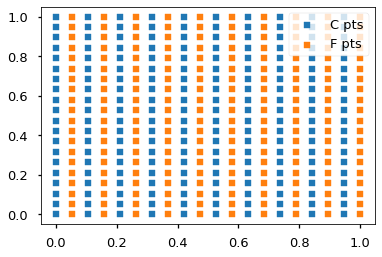

In [5]:
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
X = X.ravel()
Y = Y.ravel()

# The CF splitting, 1 == C-node and 0 == F-node
splitting = ml.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0

plt.scatter(X[C_nodes], Y[C_nodes],
            marker='s',
            s=30.0, label='C pts')
plt.scatter(X[F_nodes], Y[F_nodes],
            marker='s',
            s=30.0, label='F pts')
plt.legend()

### The `ml` hierarchy

Notice a few things about the hierarchy...

Each level has a number of attributes/functions:
- `A` is the operator on this level
- `P` interpolates **to** this level
- `R` restricts **from** this level.  Simply `R=P.T` in this case.
- `C` is a sparse matrix of strong connections
- `splitting` holds C/F information
- `presmoother` and `postsmoother` point to the relaxation routine

In [6]:
dir(ml.levels[0])

['A',
 'C',
 'P',
 'R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'postsmoother',
 'presmoother',
 'splitting']

- `Operator complexity` is the total sum of the `nnz` in all operators `A` compared to the fine level

In [7]:
Asizes = [ml.levels[i].A.nnz for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[3364, 1624, 754, 232, 128, 44]
1.8269916765755054


- `Grid Complexity` is the total sum of the unknowns per level, compared to the fine level

In [8]:
Asizes = [ml.levels[i].A.shape[0] for i in range(len(ml.levels))]
print(Asizes)
print(np.sum(Asizes)/Asizes[0])

[400, 200, 100, 40, 20, 10]
1.925


### Set up a problem and solve

Now, set $f=0$ and the initial $u$ to random and solve.

Note: you can set `accel='cg'` to use AMG as a preconditioner

In [9]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
res = []
u = ml.solve(b=f, x0=u0, residuals=res, accel='cg')

In [10]:
res = np.array(res)
res[1:] / res[:-1]

array([0.018538  , 0.00810279, 0.01603433])

### Make a bigger problem!

In [11]:
theta = np.pi / 4
epsilon = 0.01
nx = 1000
ny = nx
stencil = pyamg.gallery.diffusion.diffusion_stencil_2d(type='FD', epsilon=epsilon, theta=theta)
print(stencil)
A = pyamg.gallery.stencil_grid(stencil, (nx, ny), format='csr')

[[-0.2475 -0.505   0.2475]
 [-0.505   2.02   -0.505 ]
 [ 0.2475 -0.505  -0.2475]]


In [12]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

multilevel_solver
Number of Levels:     10
Operator Complexity:  2.260
Grid Complexity:      1.569
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0      1000000      8988004 [44.24%]
    1       333333      4984009 [24.53%]
    2       166666      4468716 [22.00%]
    3        41666       863038 [ 4.25%]
    4        20665       821995 [ 4.05%]
    5         5165       151083 [ 0.74%]
    6         1302        28590 [ 0.14%]
    7          346         6758 [ 0.03%]
    8          156         4178 [ 0.02%]
    9           32          294 [ 0.00%]



In [13]:
f = np.zeros(A.shape[0])
u0 = np.random.randn(A.shape[0])
res = []
u = ml.solve(b=f, x0=u0, residuals=res)

In [14]:
res = np.array(res)
res[1:] / res[:-1]

array([0.01764052, 0.08331184, 0.1556612 , 0.2373168 , 0.30160411,
       0.34639821, 0.37618451, 0.39596667, 0.4096154 , 0.41947275,
       0.42686905, 0.43258467, 0.43710563, 0.4407518 , 0.44374269])

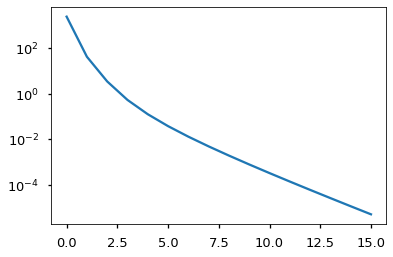

In [15]:
plt.semilogy(res)